In [11]:
import pandas
pandas.options.display.max_colwidth = None #set_option('max_colwidth', None)
pandas.options.display.max_columns = 20#None#(100)#set_option('max_columns', None)

import numpy
import pygsheets
import datetime
import scipy
import sklearn.linear_model
import sklearn.cluster
import re

import matplotlib.pyplot as mp

# import pipelines dataset

In [12]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = gas_pipes.copy()

# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig.loc[pipes_df_orig.Fuel.isin(['Gas','Hydrogen'])]

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [13]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--',numpy.nan,inplace=True)
pipes_df_orig['ProposalYear'] = pipes_df_orig['ProposalYear'].replace('',numpy.nan)
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df(start='A2')

In [14]:
region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
region_df_eu_uk = region_df_orig.copy()[(region_df_orig['Region']=='Europe') | 
                                          (region_df_orig['Country'].isin(['United Kingdom','Israel']))]

In [15]:
region_df_touse = region_df_eu.copy()

In [16]:
# subset the pipelines to use
# can't use pipes_df_touse... because some of the pipelines get eliminated if they're not in the same country...
pipes_df_touse = pipes_df_orig.loc[
    ~pipes_df_orig['Countries'].apply(
        lambda x: set(x.split(', ')).isdisjoint(set(region_df_touse['Country'].tolist()))
    )]

pipes_df_touse_h2 = pipes_df_touse.loc[(pipes_df_touse.Fuel=='Hydrogen')|
                                       (pipes_df_touse.H2Status!='')]
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.Fuel=='Gas']
pipes_df_orig_gas = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')]
country_ratios_df_touse = country_ratios_df.loc[(country_ratios_df.Country.isin(region_df_touse['Country'].tolist()))&
                                                (country_ratios_df.Fuel=='Gas')]

In [17]:
western_eu = ['Ireland', 'France', 'Belgium', 'Netherlands', 
              'Luxembourg', 'Germany', 'Austria'] 

eastern_eu = ['Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 
              'Slovakia', 'Slovenia', 'Croatia', 'Hungary', 'Romania', 'Bulgaria'] 

southern_eu = ['Portugal', 'Spain', 'Italy', 
               'Malta', 'Greece', 'Cyprus']

northern_eu = ['Sweden', 'Finland', 'Denmark']

# cost estimates for EU 27 member states

## outliers and special cases

### correct Poland-Ukraine Interconnector

In [18]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 1.5

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df_touse.Country=='Ukraine'),'MergedKmByCountry'] = 99.0

### correct Gas Interconnection Poland-Lithuania (our fractional calc doesn't get it right)

In [19]:
country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Poland'),'MergedKmByCountry'] = 343.0

country_ratios_df_touse.loc[(country_ratios_df_touse.PipelineName=='Gas Interconnection Poland-Lithuania')&
                      (country_ratios_df_touse.Country=='Lithuania'),'MergedKmByCountry'] = 165.0

## exploring alternative cost calculations

* if a given pipeline is super long and costs more than a short one per km, then should it be weighed more heavily in calculating the EU-average pipeline cost? the idea is that longer pipelines probably cost a significantly larger amount to build... look at the plot of that first perhaps

pipeline cost vs length?

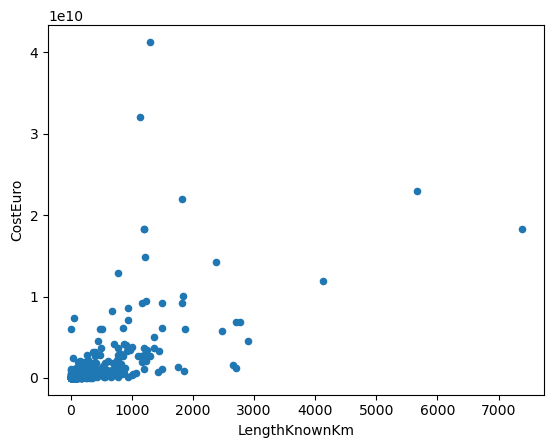

In [20]:
ax = pipes_df_orig.plot.scatter('LengthKnownKm','CostEuro')

### regression estimate: given length, estimate cost

In [21]:
pipes_df_toregress = pipes_df_touse.loc[(~pipes_df_touse.LengthKnownKm.isnull())&
                                       (~pipes_df_touse.CostEuro.isnull())&
                                       (pipes_df_touse.LengthKnownKm>0)]

# calculate projects with same name/cost, drop the first of the same pipeline names...
same_name_and_cost = pipes_df_toregress.loc[(pipes_df_toregress.duplicated('CostEuroPerKm'))&
                       (pipes_df_toregress.duplicated('PipelineName'))].drop_duplicates('PipelineName', keep='first')
pipes_df_toregress_dropdupes = pipes_df_toregress.drop(same_name_and_cost.index)

# # look at the full global dataset
# pipes_df_toregress = pipes_df_orig.loc[(~pipes_df_orig.LengthKnownKm.isnull())&
#                                         (~pipes_df_orig.CostEuro.isnull())&
#                                         (pipes_df_orig.LengthKnownKm!=0)]#&
#                                         #(pipes_df_orig.LengthKnownKm>100)&
#                                         #(pipes_df_orig.LengthKnownKm<1000)]

### gentle cluster analysis

In [22]:
num_clusters = 2
kmeans_cluster = sklearn.cluster.KMeans(n_clusters=num_clusters, 
                                        init='random', 
                                        n_init=10, 
                                        max_iter=300, 
                                        tol=1e-4,
                                       random_state=42)

km_fit = kmeans_cluster.fit_predict(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                   y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

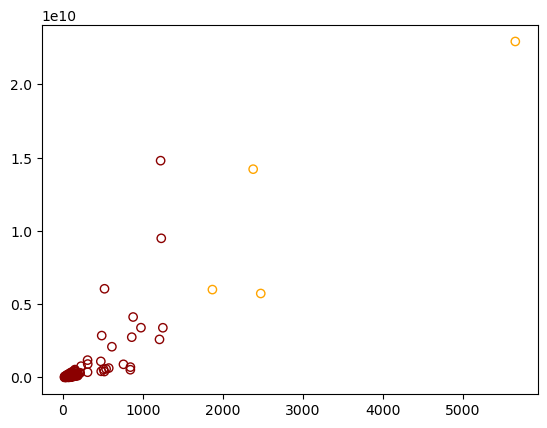

In [23]:
colors=['darkred','orange','green','blue','purple']

for i in range(num_clusters):
    mp.scatter(pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == i],
               pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1)[km_fit == i],
               edgecolor=colors[i], color='None')

#mp.xlim(0,1000)
#mp.ylim(0,0.5e10)
# mp.scatter(pipes_df_toregress.LengthKnownKm.to_numpy().reshape(-1,1)[km_fit == 2],
#            pipes_df_toregress.CostEuro.to_numpy().reshape(-1,1)[km_fit == 2],
#            color='slateblue', s=10)

In [24]:
ts_estimator = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                 y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

r_estimator = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

ols_estimator = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator.fit(X=pipes_df_toregress_dropdupes.LengthKnownKm.to_numpy().reshape(-1,1),
                  y=pipes_df_toregress_dropdupes.CostEuro.to_numpy().reshape(-1,1))

ts_slope, ts_intercept, ts_low_slope, ts_high_slope = scipy.stats.mstats.theilslopes(y=pipes_df_toregress_dropdupes.CostEuro.tolist(), 
                                                                                     x=pipes_df_toregress_dropdupes.LengthKnownKm.tolist(),
                                                                                     alpha=0.1, )

s_slope, s_intercept = scipy.stats.mstats.siegelslopes(y=pipes_df_toregress_dropdupes.CostEuro.tolist(), 
                                                       x=pipes_df_toregress_dropdupes.LengthKnownKm.tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[4.01993203]] OLS
[1.21497253] TS
[[1.13243081]] R
1.9555555555555555 scipy TS slope
2.0004776767976344 straight-up mean


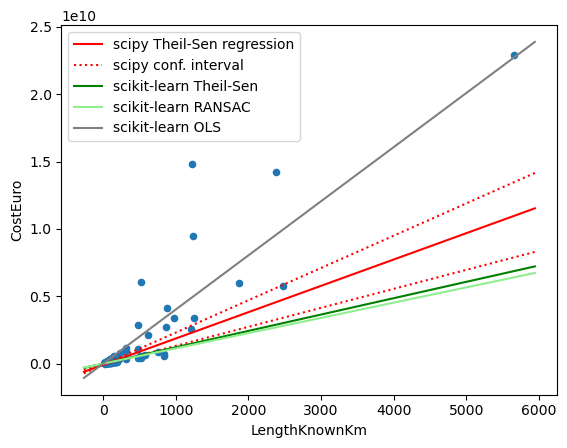

In [25]:
ax = pipes_df_toregress_dropdupes.plot.scatter('LengthKnownKm','CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred = ts_estimator.predict(xvals.reshape(-1,1))
r_pred = r_estimator.predict(xvals.reshape(-1,1))
ols_pred = ols_estimator.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope*xvals+ts_intercept, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope*xvals+ts_intercept, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope*xvals+ts_intercept, c='red', ls=':')

ax.plot(xvals, ts_pred, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred, label='scikit-learn OLS', c='gray')

ax.legend()

print(ols_estimator.coef_/1e6, "OLS")
print(ts_estimator.coef_/1e6, "TS")
print(r_estimator.estimator_.coef_/1e6, "R")
print(ts_slope/1e6, "scipy TS slope")
print(pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6, "straight-up mean")

## cost decision!

I'm going to use the full linear regression slope and the drop-duplicates average

### now use these country-specific costs as multipliers on within-country kilometers

LARGER MEAN

In [26]:
ols_estimator.coef_[0][0]/1e6

4.019932032583462

In [27]:
mean_cost_per_km = ols_estimator.coef_[0][0]/1e6

country_ratios_df_touse['TotalEstCostEuroMillionsHigh'] = numpy.nan

for idx,row in country_ratios_df_touse.iterrows():
    country_ratios_df_touse.loc[idx,'TotalEstCostEuroMillionsHigh'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_touse['CostEuroPerKm'].isna()
country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/2322650868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsHigh'] = numpy.nan


SMALLER MEAN

In [28]:
pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

2.0004776767976344

In [29]:
mean_cost_per_km = pipes_df_toregress_dropdupes.CostEuroPerKm.mean()/1e6

country_ratios_df_touse['TotalEstCostEuroMillionsLow'] = numpy.nan

for idx,row in country_ratios_df_touse.iterrows():
    country_ratios_df_touse.loc[idx,'TotalEstCostEuroMillionsLow'] = row['MergedKmByCountry'] * mean_cost_per_km

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~country_ratios_df_touse['CostEuro'].isna()

country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']
country_ratios_df_touse.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    country_ratios_df_touse[costs_exist_TF]['CostEuroPerKm']/1e6 * \
    country_ratios_df_touse[costs_exist_TF]['MergedKmByCountry']

country_ratios_df_touse.loc[(country_ratios_df_touse['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_touse['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_touse['Country']=='Italy'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

country_ratios_df_touse.loc[(country_ratios_df_touse['PipelineName']=='Trans-Adriatic Gas Pipeline')&
                            (country_ratios_df_touse['SegmentName']=='TAP Expansion')&
                            (country_ratios_df_touse['Country']=='Greece'), ['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = \
country_ratios_df.loc[(country_ratios_df.ProjectID=='P3203'),'CostEuro'].values[0]/1e6 * 2/3 * 0.5

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/275472991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsLow'] = numpy.nan


In [30]:
country_ratios_df_touse['TotalEstCostEuroMillionsMean'] = \
    country_ratios_df_touse[['TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/1592955527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_df_touse['TotalEstCostEuroMillionsMean'] = \


In [31]:
output_columns = ['Country',
                  'PipelineName',
                  'SegmentName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',
                  'TotalEstCostEuroMillionsLow',
                  'TotalEstCostEuroMillionsHigh']
country_ratios_df_touse_excel = country_ratios_df_touse[country_ratios_df_touse['Status'].isin(['Proposed','Construction'])]
country_ratios_df_touse_excel = country_ratios_df_touse.sort_values(['Status',
                                                                     'PipelineName',
                                                                     'TotalEstCostEuroMillionsLow',
                                                                     'TotalEstCostEuroMillionsHigh'],
                                                                    ascending=[True,True,False,False])
country_ratios_df_touse_excel.replace(numpy.nan, '')
country_ratios_df_touse_excel = country_ratios_df_touse_excel[output_columns]

## print export, import, and within-EU pipelines

planned pipelines to import gas into the EU

In [32]:
# get the pipelines that import into the EU, export out, and are completely within
pipes_df_eu_imports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (~pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_exports = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (~pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

pipes_df_eu_within = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')&
              (pipes_df_orig['StartCountry'].isin(region_df_touse.Country))&
              (pipes_df_orig['EndCountry'].isin(region_df_touse.Country))]

## creating 2023 version of Table 8 of last year's report (appendix)

In [33]:
pipes_df_touse.loc[(pipes_df_touse.StartRegion!='Europe')&
                            (pipes_df_touse.EndRegion=='Europe')&
                            (pipes_df_touse.Status.isin(['Proposed','Construction']))].ProjectID

249     P0463
263     P0479
358     P0732
421     P0827
1791    P3204
1792    P3205
1793    P3206
1819    P3281
Name: ProjectID, dtype: object

In [34]:
# only construction, proposed project IDs here, built on a list:
import_projectids = [
#'P0463', # Nigeria-Morocco Gas Pipeline (have in table, don't count it)
'P0479',
#'P0684', # in 2022 (Baltic Pipe Project, now operating)
'P0702',
'P0732',
'P0827', # east med (have in table but don't count it)
'P3206', # east med expansion (have in table but don't count it)
'P1321',
'P1324',
#'P1773', # this is the Siret-Khotyn Gas Pipeline, doesn't count
#'P2264',
'P3203', # Trans-Adriatic Gas Pipeline TAP Expansion, also P3204
#'P3204', # 0 new km
#'P3205', # 0 new km
#'P3281', # 0 new km
'P3335', # this is a duplicate of P2264
'P2727', # Romania-Ukraine Interconnector; this is a segment: Gheraesti-Siret Gas Pipeline (Ukraine to Romania, bidirectional), added manually
#'P3522', # UK-Ireland interconnector
'P4399'
]

all_other_projectids = list(set(country_ratios_df_touse.loc[
    country_ratios_df_touse.Status.isin(['Proposed','Construction'])].ProjectID) - set(import_projectids))

output_columns = ['Country',
                  'PipelineName',
                  'Status',
                  'CapacityBcm/y',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean',]
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(import_projectids)].sort_values(['Status','PipelineName',
                                                                                                   'TotalEstCostEuroMillionsLow'], 
                                                                                                  ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide_index()


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/1410622828.py:38: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ascending=[True,True,False])[output_columns].replace(numpy.nan,'').style.hide_index()


Country,PipelineName,Status,CapacityBcm/y,MergedKmByCountry,TotalEstCostEuroMillionsMean
Croatia,Bosnia and Herzegovina–Croatia South Interconnection Gas Pipeline,Proposed,1.500000,63.440000,41.373913
Cyprus,Cyprus-Turkey Gas Pipeline,Proposed,3.100000,48.110000,165.560823
Greece,East Med Gas Pipeline,Proposed,10.000000,1274.860000,4090.459893
Cyprus,East Med Gas Pipeline,Proposed,10.000000,569.350000,1826.791444
Greece,East Med Gas Pipeline,Proposed,10.000000,0.000000,
Cyprus,East Med Gas Pipeline,Proposed,10.000000,0.000000,
Croatia,Ionian Adriatic Gas Pipeline,Proposed,5.000000,262.010000,284.329372
Cyprus,Israel Cyprus Gas Pipeline,Proposed,4.000000,152.290000,227.443994
Bulgaria,North Macedonia–Bulgaria Gas Pipeline,Proposed,2.060000,5.190000,1.085182
Romania,Romania-Ukraine Interconnector,Proposed,,146.000000,124.999999


## creating Table (appendix)

### longer than 150 km

In [35]:
# must be longer than 150 total, and the segment must be located within the EU
projectids_threshold = list(
    set(country_ratios_df_touse.loc[(country_ratios_df_touse.MergedKmByPipeline>150)&
                                   (country_ratios_df_touse.ProjectID.isin(all_other_projectids))]['ProjectID'])
)

projectids_under_threshold = list(
    set(all_other_projectids) - set(projectids_threshold)
)

projectids_threshold.__len__()

23

In [36]:
output_columns = ['Country',
                  'PipelineName',
                  #'Status',
                  'CapacityBcm/y',
                  'MergedKmByPipeline',
                  'MergedKmByCountry',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

country_ratios_df_touse.replace(numpy.nan,'').loc[
    (country_ratios_df_touse.ProjectID.isin(projectids_threshold))].sort_values([
    'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide_index()


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/4227614377.py:13: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  'Status','PipelineName','TotalEstCostEuroMillionsLow'], ascending=[True,True,False])[output_columns].style.hide_index()


Country,PipelineName,CapacityBcm/y,MergedKmByPipeline,MergedKmByCountry,TotalEstCostEuroMillionsMean
Bulgaria,Bulgaria-Serbia Interconnector Gas Pipeline,1.800000,170.000000,63.710000,50.218470
Poland,Gustorzyn-Wronów Gas Pipeline,,308.000000,308.000000,927.143095
Italy,Methanization of Sardinia Project,,573.000000,573.000000,642.853210
Poland,Pogórska-Wola-Tworzen Gas Pipeline,,168.000000,168.000000,300.500001
Italy,Adriatica Pipeline,8.800000,170.000000,170.000000,553.600000
Germany,Bielefeld-Magdeburg Gas Pipeline,,159.000000,159.000000,478.622572
Romania,Black Sea Shore–Podișor Gas Pipeline,,308.000000,308.000000,360.000000
Portugal,Celorico-Spanish Border Gas Pipeline,,162.000000,162.000000,114.999999
Cyprus,Cyprus-Egypt Gas Pipeline,8.000000,310.000000,32.950000,97.514057
Czech Republic,Czech-Polish Interconnector Gas Pipeline (CPI),,207.000000,155.340000,210.670176


### shorter than 150 km

In [37]:
below_threshold_df = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(projectids_under_threshold)]#.groupby('Status')

below_threshold_df.groupby('Status')[['MergedKmByCountry',
                                      'TotalEstCostEuroMillionsMean',
                                      'TotalEstCostEuroMillionsLow',
                                      'TotalEstCostEuroMillionsHigh']].sum()

,MergedKmByCountry,TotalEstCostEuroMillionsMean,TotalEstCostEuroMillionsLow,TotalEstCostEuroMillionsHigh
Status,,,,
Construction,345.70,317.051417,315.839744,318.263089
Proposed,2937.75,6379.748809,5116.105537,7643.392080


# import terminals now

In [39]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
#spreadsheet = gc.open_by_key('1BHiidrJnzh96Em3KrqBpCoWaJ3GB5OeCY9dHVaEDEFs') # mar 22 2022 version for EGT

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [40]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# only keep LNG terminals (remove oil)
terms_df_orig = terms_df_orig.loc[terms_df_orig.Fuel=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig.Wiki!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig.Status!='']

In [42]:
terms_df_touse = terms_df_orig.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                   (terms_df_orig.Fuel=='LNG')]
terms_df_touse_imports = terms_df_touse.loc[(terms_df_orig['Country'].isin(region_df_touse['Country']))&
                                            (terms_df_touse['Import/Export']=='Import')]

### outliers and special cases

#### pull out what to regress for costs

In [43]:
terms_df_floating_toregress = terms_df_touse.loc[(terms_df_touse['Import/Export']=='Import')&
                                                 (terms_df_touse.Floating=='yes')&
                                                 (~terms_df_touse['CostEuroPerBcm/y'].isnull())]
terms_df_floating_toregress_dropdupes = terms_df_floating_toregress.drop_duplicates('CostEuroPerBcm/y')

In [44]:
terms_df_onshore_toregress = terms_df_touse.loc[(terms_df_touse['Import/Export']=='Import')&
                                                (terms_df_touse.Floating=='')&
                                                (~terms_df_touse['CostEuroPerBcm/y'].isnull())&
                                                (~terms_df_touse.UnitName.str.contains('expansion', flags=re.IGNORECASE, regex=True))]
terms_df_onshore_toregress_dropdupes = terms_df_onshore_toregress.drop_duplicates('CostEuroPerBcm/y')

### regressions for costs

#### floating terminals

In [45]:
ts_estimator_f = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                 y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator_f = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator_f = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator_f.fit(X=terms_df_floating_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                  y=terms_df_floating_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope_f, ts_intercept_f, ts_low_slope_f, ts_high_slope_f = scipy.stats.mstats.theilslopes(y=terms_df_floating_toregress.CostEuro.tolist(), 
                                                                            x=terms_df_floating_toregress['CapacityInBcm/y'].tolist(),
                                                                            alpha=0.1, )

s_slope_f, s_intercept_f = scipy.stats.mstats.siegelslopes(y=terms_df_floating_toregress.CostEuro.tolist(), 
                                                       x=terms_df_floating_toregress['CapacityInBcm/y'].tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[70.1053435]] OLS
[62.5] TS
[[60.67546407]] R
66.66666666666667 scipy TS slope
90.19328627811765 straight-up mean


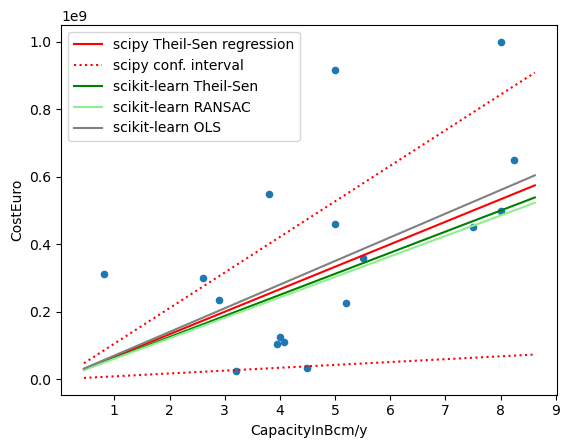

In [46]:
ax = terms_df_floating_toregress_dropdupes.plot.scatter('CapacityInBcm/y', 'CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred_f = ts_estimator_f.predict(xvals.reshape(-1,1))
r_pred_f = r_estimator_f.predict(xvals.reshape(-1,1))
ols_pred_f = ols_estimator_f.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope_f*xvals+ts_intercept_f, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope_f*xvals+ts_intercept_f, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope_f*xvals+ts_intercept_f, c='red', ls=':')

ax.plot(xvals, ts_pred_f, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred_f, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred_f, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator_f.coef_/1e6, "OLS")
print(ts_estimator_f.coef_/1e6, "TS")
print(r_estimator_f.estimator_.coef_/1e6, "R")
print(ts_slope_f/1e6, "scipy TS slope")
print(terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6, "straight-up mean")

#### onshore terminals

In [47]:
ts_estimator_o = sklearn.linear_model.TheilSenRegressor(random_state=42, fit_intercept=False)
ts_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                 y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

r_estimator_o = sklearn.linear_model.RANSACRegressor(random_state=42,
                                                   estimator=sklearn.linear_model.LinearRegression(fit_intercept=False))
r_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

ols_estimator_o = sklearn.linear_model.LinearRegression(fit_intercept=False)
ols_estimator_o.fit(X=terms_df_onshore_toregress['CapacityInBcm/y'].to_numpy().reshape(-1,1),
                  y=terms_df_onshore_toregress.CostEuro.to_numpy().reshape(-1,1))

ts_slope_o, ts_intercept_o, ts_low_slope_o, ts_high_slope_o = scipy.stats.mstats.theilslopes(y=terms_df_onshore_toregress.CostEuro.tolist(), 
                                                                            x=terms_df_onshore_toregress['CapacityInBcm/y'].tolist(),
                                                                            alpha=0.1, )

s_slope_o, s_intercept_o = scipy.stats.mstats.siegelslopes(y=terms_df_onshore_toregress.CostEuro.tolist(), 
                                                       x=terms_df_onshore_toregress['CapacityInBcm/y'].tolist())

/Users/baird/mambaforge/envs/gem/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[83.53597048]] OLS
[125.] TS
[[82.24138621]] R
77.86814560898576 scipy TS slope


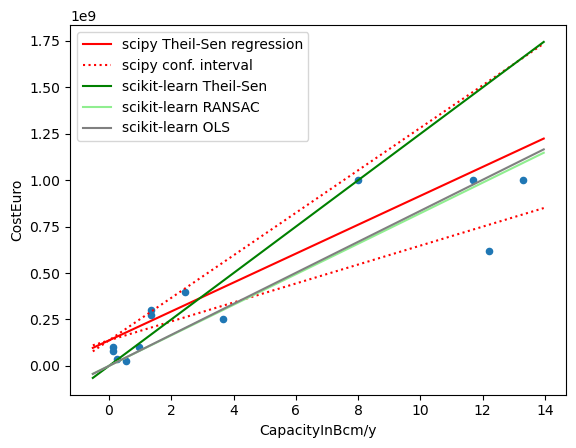

In [48]:
ax = terms_df_onshore_toregress_dropdupes.plot.scatter('CapacityInBcm/y', 'CostEuro')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

#ax.set_xlim(0,200)
#ax.set_ylim(0,0.4e9)
xvals = numpy.linspace(xmin,xmax,1000)

ts_pred_o = ts_estimator_o.predict(xvals.reshape(-1,1))
r_pred_o = r_estimator_o.predict(xvals.reshape(-1,1))
ols_pred_o = ols_estimator_o.predict(xvals.reshape(-1,1))

ax.plot(xvals, ts_slope_o*xvals+ts_intercept_o, label = 'scipy Theil-Sen regression', c='red')
ax.plot(xvals, ts_low_slope_o*xvals+ts_intercept_o, label='scipy conf. interval', c='red', ls=':')
ax.plot(xvals, ts_high_slope_o*xvals+ts_intercept_o, c='red', ls=':')

ax.plot(xvals, ts_pred_o, label='scikit-learn Theil-Sen', c='green')
ax.plot(xvals, r_pred_o, label='scikit-learn RANSAC', c='lightgreen')
ax.plot(xvals, ols_pred_o, label='scikit-learn OLS', c='gray')

#ax.plot(

#ax.plot(xvals, s_slope*xvals+s_intercept, label = 'scipy.stats', c='orange')

ax.legend()

print(ols_estimator_o.coef_/1e6, "OLS")
print(ts_estimator_o.coef_/1e6, "TS")
print(r_estimator_o.estimator_.coef_/1e6, "R")
print(ts_slope_o/1e6, "scipy TS slope")

In [49]:
terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

90.19328627811765

In [50]:
terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

200.6206502353846

## calculate floating costs (high and low estimates)

SMALLER MEAN

In [51]:
print(ols_estimator_f.coef_[0][0]/1e6)
print(ols_estimator_o.coef_[0][0]/1e6)

70.10534349959265
83.53597048210717


In [52]:
mean_cost_per_bcmy_floating = ols_estimator_f.coef_[0][0]/1e6
mean_cost_per_bcmy_onshore = ols_estimator_o.coef_[0][0]/1e6

terms_df_eu27_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                                                 (terms_df_touse['Import/Export']=='Import')]

# do for floating
terms_df_eu27_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan

terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_eu27_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsLow'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEuro'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/1020654288.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsLow'] = numpy.nan
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/1020654288.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsLow'] = \


LARGER MEAN

In [53]:
mean_cost_per_bcmy_floating = terms_df_floating_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6
mean_cost_per_bcmy_onshore = terms_df_onshore_toregress_dropdupes['CostEuroPerBcm/y'].mean()/1e6

# terms_df_eu27_import_future = terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
#                                                  (terms_df_touse['Import/Export']=='Import')]

# do for floating
terms_df_eu27_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan

terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']=='yes'),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_floating

# now do for onshore
#terms_df_eu27_import_future.loc[:,'TotalEstCostEuroMillionsLow'] = numpy.nan
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'TotalEstCostEuroMillionsHigh'] = \
terms_df_eu27_import_future.loc[(terms_df_eu27_import_future['Floating']==''),
                                'CapacityInBcm/y'] * mean_cost_per_bcmy_onshore

# then replace any that we have already
# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_eu27_import_future['CostEuro'].isna()
terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \
    terms_df_eu27_import_future[costs_exist_TF]['CostEuro']/1e6 #*euro_multiplier/1e6

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/1859383821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsHigh'] = numpy.nan
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/1859383821.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future.loc[costs_exist_TF,'TotalEstCostEuroMillionsHigh'] = \


In [54]:
terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \
    terms_df_eu27_import_future[['TotalEstCostEuroMillionsLow', 'TotalEstCostEuroMillionsHigh']].mean(axis=1)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/4095347764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TotalEstCostEuroMillionsMean'] = \


### correct outliers/special cases

In [55]:
# Zeebrugge terminal is 116 million for BOTH expansion projects, so set one equal to zero so it's not counted twice
#T042601	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2024 Expansion
#T042602	https://www.gem.wiki/Fluxys_Zeebrugge_LNG_Terminal	Zeebrugge LNG Terminal, 2026 Expansion
outliers_comboids = ['T042602']
terms_df_eu27_import_future.loc[
    terms_df_eu27_import_future.ComboID.isin(outliers_comboids),
    ['TotalEstCostEuroMillionsMean','TotalEstCostEuroMillionsLow','TotalEstCostEuroMillionsHigh']] = 0.0

# creating table 7 (appendix) from 2022 report

In [56]:
terms_df_eu27_import_future['CapacityInBcm/y'].sum()

235.74999999999997

In [58]:
output_columns = ['Country',
                  #'TerminalName',
                  'TerminalNameUnitName',
                  #'UnitName',
                  'CapacityInBcm/y',
                  #'Status',
                  #'Import/Export',
                  'TotalEstCostEuroMillionsMean']#,
                  #'TotalEstCostEuroMillionsLow',
                  #'TotalEstCostEuroMillionsHigh']

terms_df_eu27_import_future['TerminalNameUnitName'] = (terms_df_eu27_import_future.TerminalName + ' ' + terms_df_eu27_import_future.UnitName).str.strip()
terms_df_eu27_import_future.sort_values(['Status','TerminalNameUnitName'],
                                        ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide_index()

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/3698264527.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  terms_df_eu27_import_future['TerminalNameUnitName'] = (terms_df_eu27_import_future.TerminalName + ' ' + terms_df_eu27_import_future.UnitName).str.strip()
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/3698264527.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ascending=[True,True])[output_columns].replace(numpy.nan,'').style.hide_index()


Country,TerminalNameUnitName,CapacityInBcm/y,TotalEstCostEuroMillionsMean
Greece,Alexandroupolis FSRU,5.500000,360.000000
Germany,Brunsbüttel FSRU,8.000000,1000.000000
Cyprus,Cyprus LNG Terminal,0.820000,312.000000
Estonia,Paldiski FSRU,,500.000000
Germany,Stade FSRU,5.000000,400.746574
Belgium,Zeebrugge LNG Terminal 2024 Expansion,6.390000,116.000000
Belgium,Zeebrugge LNG Terminal 2026 Expansion,1.770000,0.000000
Poland,Świnoujście Polskie LNG Terminal Expansion 2,2.100000,298.364452
Greece,Argo FSRU,5.200000,226.500000
Germany,Brunsbüttel LNG Terminal,8.000000,1000.000000


# creating table 2 - future gas infra in EU countries

In [61]:
terms_df_eu27_import_future.groupby('Country')[['TotalEstCostEuroMillionsMean']].sum()

,TotalEstCostEuroMillionsMean
Country,
Belgium,116.000000
Croatia,1019.548173
Cyprus,312.000000
Estonia,1150.000000
France,2459.345639
Germany,7263.503190
Greece,2324.059861
Ireland,858.388219
Italy,4386.554128


In [62]:
# table 1 shows country totals of pipeline length, cost, LNG capacity, cost, total cost
table2_columns = ['PipelineLengthKm','PipelineCostMillionEuro',
                  'LNGImportCapacityBcm/y','LNGTerminalCostMillionEuro','TotalCostMillionEuro']
table2_df = pandas.DataFrame(columns=table2_columns, index=region_df_touse.Country.tolist())

table2_df['PipelineLengthKm'] = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['MergedKmByCountry'].sum()

table2_df['PipelineCostMillionEuro'] = country_ratios_df_touse.loc[country_ratios_df_touse.ProjectID.isin(
    import_projectids+all_other_projectids)].groupby('Country')['TotalEstCostEuroMillionsMean'].sum()

# add half of Trans-Adriatic expansion to Italy, half to Greece
#table2_df.loc['Greece','PipelineCostMillionEuro']+=1035/2
#table2_df.loc['Italy','PipelineCostMillionEuro']+=1035/2

table2_df['LNGImportCapacityBcm/y'] = terms_df_eu27_import_future.groupby('Country')['CapacityInBcm/y'].sum()
table2_df['LNGTerminalCostMillionEuro'] = terms_df_eu27_import_future.groupby('Country')['TotalEstCostEuroMillionsMean'].sum()
table2_df['TotalCostMillionEuro'] = table2_df.loc[:,('PipelineCostMillionEuro','LNGTerminalCostMillionEuro')].sum(axis=1)

if 'Total' in table2_df.index:
    table2_df.drop(index='Total', inplace=True)   
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df = table2_df.append(total)

else:
    total = table2_df.sum(axis=0)
    total.name='Total'
    table2_df = table2_df.append(total)

# replace NaN with ''
table2_df.replace(numpy.nan, '', inplace=True)
table2_df.replace(0.0, '', inplace=True)


/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_1725/2538600389.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table2_df = table2_df.append(total)


In [63]:
table2_df#['LNGImportCapacityBcm/y'][:-1].replace('',numpy.nan).sum()

,PipelineLengthKm,PipelineCostMillionEuro,LNGImportCapacityBcm/y,LNGTerminalCostMillionEuro,TotalCostMillionEuro
Austria,59.39,178.776066,,,178.776066
Belgium,,,8.16,116.0,116.0
Bulgaria,1124.62,2577.931241,,,2577.931241
Croatia,870.54,1016.529627,10.2,1019.548173,2036.077799
Cyprus,921.15,2684.692924,0.82,312.0,2996.692924
Czech Republic,157.95,218.52681,,,218.52681
Denmark,,,,,
Estonia,1.2,3.612246,6.12,1150.0,1153.612246
Finland,,,,,
France,,,18.47,2459.345639,2459.345639


# creating table 4 from report (nsew_eu)

In [64]:
import_projectids

['P0479',
 'P0702',
 'P0732',
 'P0827',
 'P3206',
 'P1321',
 'P1324',
 'P3203',
 'P3335',
 'P2727',
 'P4399']

In [81]:
region_list = [western_eu,eastern_eu,southern_eu,northern_eu]
index_list = ['Western EU','Eastern EU','Southern EU','Northern EU']
project_list = []

table4_nsew = pandas.DataFrame(0, columns=['EstCostMillionEuroConstruction',
                                           'CostNumPipesConstruction',
                                           'CostNumTermsConstruction',
                                           'PipeLengthConstruction',
                                        'CapacityInBcm/yConstruction',
                                           'CapacNumPipesConstruction',
                                           'CapacNumTermsConstruction',
                                           'CapacPipesConstruction',
                                           'CapacTermsConstruction',
                                        'EstCostMillionEuroProposed',
                                           'CostNumPipesProposed',
                                           'CostNumTermsProposed',
                                           'PipeLengthProposed',
                                        'CapacityInBcm/yProposed',
                                           'CapacNumPipesProposed',
                                           'CapacNumTermsProposed',
                                           'CapacPipesProposed',
                                           'CapacTermsProposed'
                                          ], index=range(4))

terms_w_eu = pandas.DataFrame()
terms_n_eu = pandas.DataFrame()
terms_s_eu = pandas.DataFrame()
terms_e_eu = pandas.DataFrame()

pipes_w_eu = pandas.DataFrame()
pipes_n_eu = pandas.DataFrame()
pipes_s_eu = pandas.DataFrame()
pipes_e_eu = pandas.DataFrame()

for idx,row in table4_nsew.iterrows():
    
    for STATUS in ['Proposed','Construction']:
        
        # for proposed
        # for pipeline costs, we don't care about imports only, we also care about general pipelines
        pipeline_cost = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].sum()
        
        pipe_cost_num = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].count()
        
        
        pipe_length = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]))]['MergedKmByCountry'].sum()

        pipeline_capacity = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))]['CapacityBcm/y'].sum()
        
        pipe_cap_num = pipes_df_orig_gas.loc[(pipes_df_orig_gas.ProjectID.isin(import_projectids)) &
                                (pipes_df_orig_gas.EndCountry.isin(region_list[idx])) &
                                (pipes_df_orig_gas.Status.isin([STATUS]))]['CapacityBcm/y'].count()

        terminal_cost = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].sum()
        term_num = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['TotalEstCostEuroMillionsMean'].count()

        terminal_capacity = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]['CapacityInBcm/y'].sum()

        # pipelines are import only
        which_pipelines_df = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin([STATUS])) &
                               (country_ratios_df_touse.Country.isin(region_list[idx]) &
                               (country_ratios_df_touse.ProjectID.isin(import_projectids)))]
        which_terminals_df = terms_df_eu27_import_future.loc[(terms_df_eu27_import_future.Status.isin([STATUS])) &
                                    (terms_df_eu27_import_future.Country.isin(region_list[idx]))]
        
        #print(which_terminals_df.ComboID)

        if index_list[idx]=='Western EU':
            terms_w_eu = pandas.concat([terms_w_eu,which_terminals_df])
            pipes_w_eu = pandas.concat([pipes_w_eu,which_pipelines_df])
        if index_list[idx]=='Northern EU':
            terms_n_eu = pandas.concat([terms_n_eu,which_terminals_df])
            pipes_n_eu = pandas.concat([pipes_n_eu,which_pipelines_df])
        if index_list[idx]=='Eastern EU':
            terms_e_eu = pandas.concat([terms_e_eu,which_terminals_df])
            pipes_e_eu = pandas.concat([pipes_e_eu,which_pipelines_df])
        if index_list[idx]=='Southern EU':
            terms_s_eu = pandas.concat([terms_s_eu,which_terminals_df])
            pipes_s_eu = pandas.concat([pipes_s_eu,which_pipelines_df])

        table4_nsew.loc[idx, 'EstCostMillionEuro'+STATUS] += terminal_cost+pipeline_cost
        table4_nsew.loc[idx, 'CapacityInBcm/y'+STATUS] += terminal_capacity+pipeline_capacity
        table4_nsew.loc[idx, 'CapacTerms'+STATUS] = terminal_capacity
        table4_nsew.loc[idx, 'CapacPipes'+STATUS] = pipeline_capacity
        table4_nsew.loc[idx, 'CostNumTerms'+STATUS] = term_num
        table4_nsew.loc[idx, 'CapacNumTerms'+STATUS] = term_num
        table4_nsew.loc[idx, 'CostNumPipes'+STATUS] = pipe_cost_num
        table4_nsew.loc[idx, 'CapacNumPipes'+STATUS] = pipe_cap_num
        table4_nsew.loc[idx, 'PipeLength'+STATUS] = pipe_length

table4_nsew.index = index_list

# add trans-adriatic
#table4_nsew.loc['Southern EU','EstCostMillionEuroProposed'] += 1035.

In [82]:
table4_nsew

,EstCostMillionEuroConstruction,CostNumPipesConstruction,CostNumTermsConstruction,PipeLengthConstruction,CapacityInBcm/yConstruction,CapacNumPipesConstruction,CapacNumTermsConstruction,CapacPipesConstruction,CapacTermsConstruction,EstCostMillionEuroProposed,CostNumPipesProposed,CostNumTermsProposed,PipeLengthProposed,CapacityInBcm/yProposed,CapacNumPipesProposed,CapacNumTermsProposed,CapacPipesProposed,CapacTermsProposed
Western EU,1516.746574,0,4,0.00,21.16,0,4,0,21.16,12298.571726,10,18,712.39,103.62,0,18,0.00,103.62
Eastern EU,2133.277434,10,2,709.91,2.10,0,2,0,2.10,12407.542483,53,7,5506.53,78.06,4,7,40.56,37.50
Southern EU,1574.853210,4,2,748.50,6.32,0,2,0,6.32,24870.563725,35,12,5605.11,102.15,5,12,37.10,65.05
Northern EU,0.000000,0,0,0.00,0.00,0,0,0,0.00,0.000000,0,0,0.00,0.00,0,0,0.00,0.00


# creating figure 1 data

sum of Table 1 columns...

In [70]:
figure1_table_columns = ['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro','Total']
figure1_table_df = pandas.DataFrame(0, columns=figure1_table_columns, index=region_df_touse.Country,)


# for proposed
figure1_table_df['TotalProposedCostMillionEuro'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalProposedCostMillionEuro'] = \
figure1_table_df['TotalProposedCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Proposed'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                    fill_value=0)

figure1_table_df.loc['Italy','TotalProposedCostMillionEuro'] += 1035/2.
figure1_table_df.loc['Greece','TotalProposedCostMillionEuro'] += 1035/2.

# for construction
figure1_table_df['TotalConstructionCostMillionEuro'] = \
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum()

figure1_table_df['TotalConstructionCostMillionEuro'] = \
figure1_table_df['TotalConstructionCostMillionEuro'].add( \
terms_df_eu27_import_future.loc[terms_df_eu27_import_future.Status.isin(
    ['Construction'])].groupby(['Country'])['TotalEstCostEuroMillionsMean'].sum(), \
                                                         fill_value=0, axis=0)

figure1_table_df['Total'] = \
figure1_table_df[['TotalConstructionCostMillionEuro','TotalProposedCostMillionEuro']].sum(axis=1)
figure1_table_df.sort_values(['Total','Country'], ascending=[False, True], inplace=True)

figure1_table_df.replace(numpy.nan, '', inplace=True)
figure1_table_df.replace(0, '', inplace=True)

In [71]:
figure1_table_df

,TotalConstructionCostMillionEuro,TotalProposedCostMillionEuro,Total
Country,,,
Greece,440.0,10663.977119,11103.977119
Italy,822.85321,9406.572048,10229.425258
Germany,1400.746574,7620.632034,9021.378608
Poland,1553.007548,1983.479211,3536.486759
Cyprus,312.0,2684.692924,2996.692924
Spain,,2854.159106,2854.159106
Romania,,2700.791303,2700.791303
Bulgaria,76.65764,2501.273601,2577.931241
France,,2459.345639,2459.345639


# report numbers

In [72]:
# key points
# num of gas pipelines under const in EU
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(['Construction'])]['MergedKmByCountry'].sum()

1458.41

In [73]:
# total cost
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(['Construction'])]['TotalEstCostEuroMillionsLow'].sum()

1925.5585489067287

In [74]:
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(['Construction'])]['TotalEstCostEuroMillionsHigh'].sum()

2549.973835715706

In [75]:
# number of distinct projects
unique_const = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Construction']))].ProjectID.unique().tolist()
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_const)]['LengthMergedKm'].size)

97.79375
16


In [76]:
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(['Proposed'])]['MergedKmByCountry'].sum()

11824.029999999999

In [77]:
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(['Proposed'])]['TotalEstCostEuroMillionsLow'].sum()

25857.754656690784

In [78]:
country_ratios_df_touse.loc[country_ratios_df_touse.Status.isin(['Proposed'])]['TotalEstCostEuroMillionsHigh'].sum()

32437.46006053793

In [ ]:
# number of distinct projects
unique_prop = country_ratios_df_touse.loc[(country_ratios_df_touse.Status.isin(['Proposed']))].ProjectID.unique().tolist()
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].mean())
print(pipes_df_orig.loc[pipes_df_orig.ProjectID.isin(unique_prop)]['LengthMergedKm'].size)

# how many announced since war started?

# commissioned in 2022/2023

In [ ]:
pipes_df_touse.loc[(pipes_df_touse.Status=='Operating')&
                   (pipes_df_touse.StartYearEarliest==2022)][['PipelineName',
                                                              'Wiki',
                                                              'Countries',
                                                              'CapacityBcm/y',
                                                              'CostEuro',
                                                              'LengthKnownKm']].set_index('PipelineName')

In [ ]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status=='Operating')&
                           (terms_df_touse_imports.StartYearEarliest.isin([2022,2023]))][['ComboID',
                                                                              'TerminalName',
                                                                              'UnitName',
                                                                              'Wiki',
                                                                              'Country',
                                                                              'CapacityInBcm/y',
                                                                              'CostEuro',
                                                                              'StartYear1','StartMonth1']].set_index('TerminalName').replace(numpy.nan,'')

## starting in 2023 under const

In [ ]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status.isin(['Construction','Proposed']))&
                           (terms_df_touse_imports.StartYearEarliest.isin([2023,2024,2025,2026,2027,2028,2029,2030]))].groupby(['StartYearEarliest',
                                                                                                           'Status'])[['CapacityInBcm/y']].sum()

# existing capacity

In [ ]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Operating']))&
                   (terms_df_touse['Import/Export']=='Import')]['CapacityInBcm/y'].sum()

In [ ]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Operating']))&
                   (terms_df_touse['Import/Export']=='Import')
                  ].groupby('StartYear1')[['CapacityInBcm/y']].sum(min_count=0).cumsum()

In [ ]:
terms_df_touse.loc[(terms_df_touse.Status.isin(['Proposed','Construction']))&
                   (terms_df_touse['Import/Export']=='Import')
                  ].groupby('StartYearEarliest')[['CapacityInBcm/y']].sum()#.cumsum()

proposed since 2022

In [ ]:
terms_df_touse_imports.loc[terms_df_touse_imports.ProposalYear==2022]['CapacityInBcm/y'].sum()

began construction since 2022

In [ ]:
terms_df_touse_imports.loc[(terms_df_touse_imports.Status.isin(['Construction','Operating']))&
                           (terms_df_touse_imports.ConstructionYear==2022)]['CapacityInBcm/y'].sum()

started since 2022

In [ ]:
terms_df_touse_imports.loc[terms_df_touse_imports.StartYearEarliest.isin([2022,2023])]['CapacityInBcm/y'].sum()

# cancellations per year

# hydrogen exploring

In [ ]:
pipes_df_touse = pipes_df_touse.loc[pipes_df_touse.H2Status!='']
pipes_df_touse_h2.H2Status.unique()

In [ ]:
pipes_df_touse_h2.loc[pipes_df_touse_h2.Fuel=='Hydrogen'][['ProjectID','Status','H2Status']]

In [ ]:
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Pre-construction (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Speculative (H2 only)'].shape)
print(pipes_df_touse_h2.loc[pipes_df_touse_h2.H2Status=='Proposed'].shape)

In [ ]:
pipes_df_touse_h2.groupby('H2Status')[['LengthMergedKm']].count()#.sum()

In [ ]:
pipes_df_touse_h2.groupby(['H2Status','H2Type'])[['LengthMergedKm']].sum()

* how many H2 pipelines are planning to be 100%? blended?
  * A: really, none; the Malta-Italy Gas Pipeline is actually seeming realistic-ish but has language about "up to 100%" rather than a confirmation

## hydrogen table 1

In [ ]:
country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].MergedKmByCountry.sort_values()

In [ ]:
# country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].groupby(
#     ['H2Status','Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)

country_ratios_df_touse.loc[country_ratios_df_touse.H2Status!=''].groupby(
    ['Country'])[['MergedKmByCountry']].sum().sort_values('MergedKmByCountry', ascending=False)